#  <center> Speech Emotion Recognition <center>

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that auido.
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
        

Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions  Statement                                               Path
0  surprise          1  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral          1  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust          1  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust          1  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral          2  /kaggle/input/ravdess-emotional-speech-audio/a...

In [4]:
Ravdess_df.shape

(1440, 3)

In [5]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement   1   2
Emotions         
angry      96  96
calm       96  96
disgust    96  96
fear       96  96
happy      96  96
neutral    48  48
sad        96  96
surprise   96  96

In [6]:
# creating a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...


## Data Visualisation ------------------

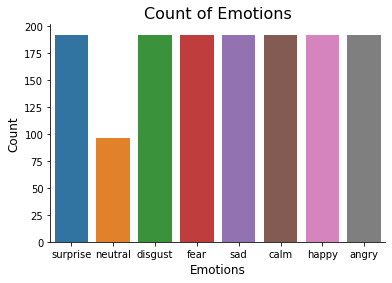

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

In [8]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

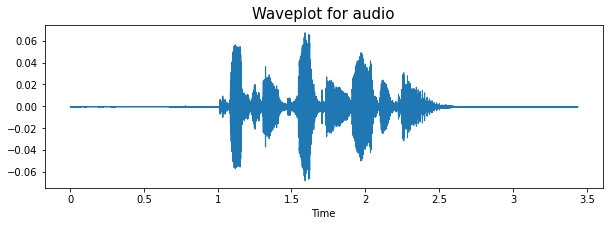

In [9]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-01-01-01-01-03.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

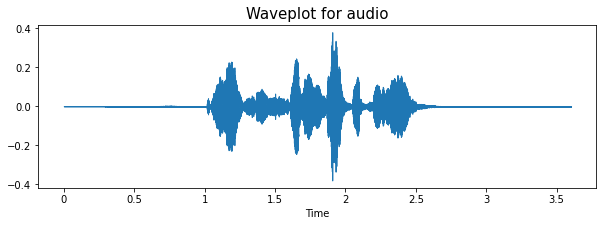

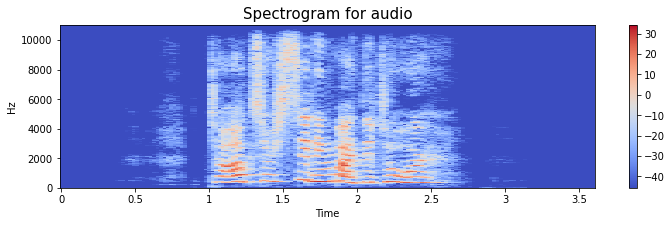

In [10]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

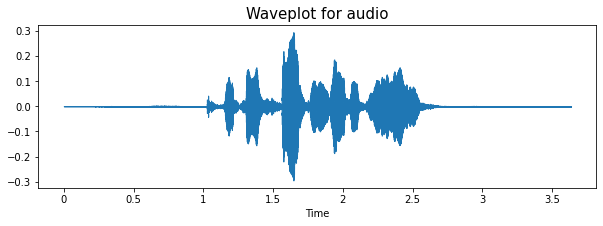

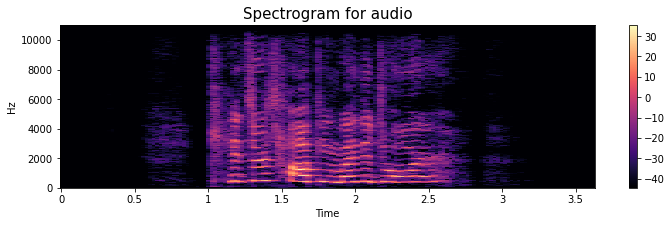

In [11]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

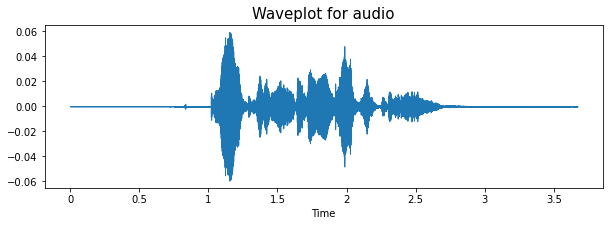

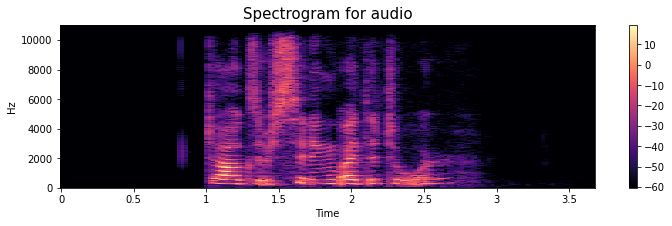

In [12]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

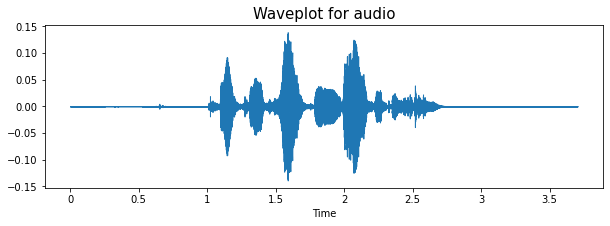

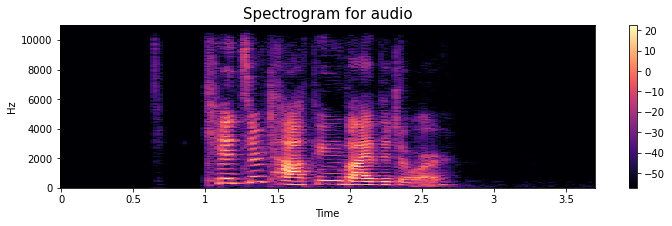

In [13]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

## Data Augmentation


In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

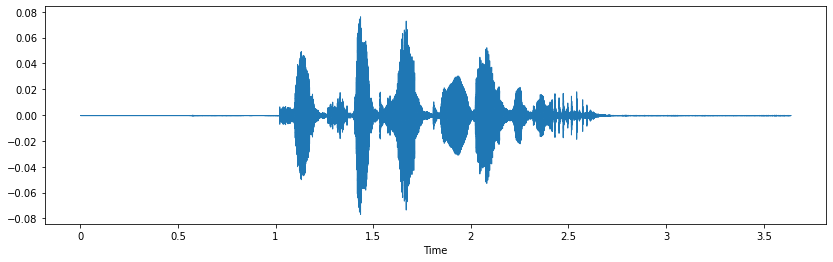

In [15]:
#1. Simple Audio
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

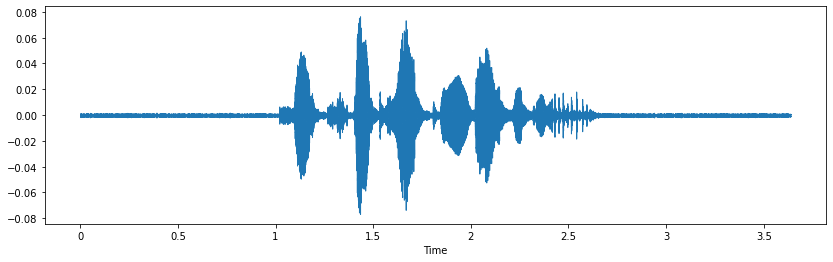

In [16]:
#2. Noise Injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

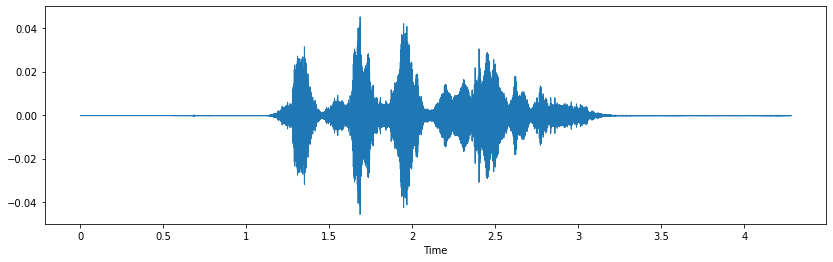

In [17]:
#3. Stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

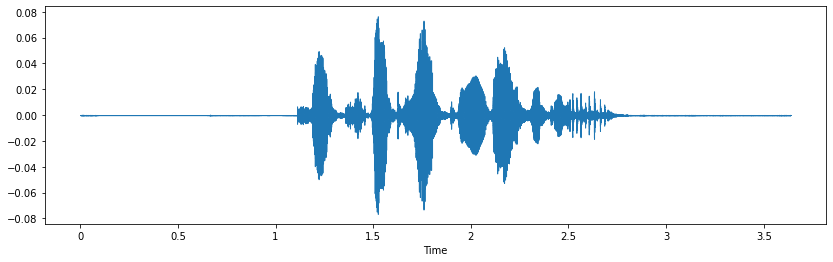

In [18]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

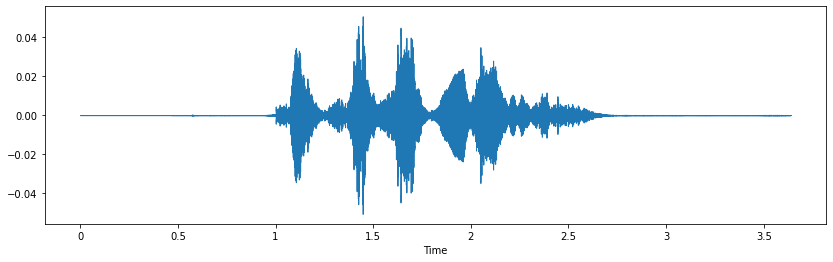

In [19]:
#Pitchhhhhhhhhhhhhhhhhhhh
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction


In [20]:

def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

# funtion to transform audio
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


    #randomly transforming audio data
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)#np.vstack((result, res2)) # stacking vertically

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)#np.vstack((result, res3)) # stacking vertically

    return result

In [21]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape


((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [22]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 104)
(20, 104)
(20, 104)
(20, 101)
(20, 101)
(20, 101)
(20, 107)
(20, 107)
(20, 107)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)


In [23]:
len(X), len(Y), data_path.Path.shape

(4275, 4275, (1440,))

In [24]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [25]:
Features = dfm.copy()
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

0  \
0  [-769.17267, -766.7206, -716.3148, -660.1502, ...   
1  [-842.3755, -811.6638, -767.0175, -718.32983, ...   
2  [-453.494605448421, -413.45914139602854, -407....   
3  [-841.74243, -841.74243, -841.74243, -841.7424...   
4  [-841.74243, -841.74243, -841.74243, -841.7424...   

                                                   1  \
0  [0.0, 3.1586719, -32.922478, -52.89432, -18.05...   
1  [-0.7242323, -18.475267, -31.59216, -32.44238,...   
2  [-10.839729078613079, -7.352160075184528, -5.1...   
3  [0.0, 0.0, 0.0, 0.0, 0.14836241, 0.0902124, 0....   
4  [0.0, 0.0, 0.0, 0.0, 0.14836241, 0.0902124, 0....   

                                                   2  \
0  [0.0, 2.292421, 22.974623, -7.5150857, -38.203...   
1  [1.1959844, 5.258437, -0.5301509, -15.42464, -...   
2  [-0.4628431697270086, -2.241527700219195, -0.8...   
3  [0.0, 0.0, 0.0, 0.0, 0.08600661, 0.055090826, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.08600661, 0.055090826, ...   

                                                   3  \
0  [0.0, 1.0394392, 5.1416974, 28.229137, 25.3109...   
1  [0.14296375, 8.515469, 25.454031, 33.406044, 3...   
2  [0.05972548932595245, 1.2723280998699251, 3.76...   
3  [0.0, 0.0, 0.0, 0.0, 0.0007863119, 0.006314475...   
4  [0.0, 0.0, 0.0, 0.0, 0.0007863119, 0.006314475...   

                                                   4  \
0  [0.0, -0.35461912, -3.1802936, 8.344682, 3.121...   
1  [0.48472396, 2.394704, 3.7548923, 2.37531, -1....   
2  [-3.4988972183637066, -0.883343020464632, 2.72...   
3  [0.0, 0.0, 0.0, 0.0, -0.08452024, -0.044026986...   
4  [0.0, 0.0, 0.0, 0.0, -0.08452024, -0.044026986...   

                                                   5  \
0  [0.0, -1.618254, 3.999816, -3.0527668, -11.494...   
1  [0.75833946, -1.8518243, -8.903948, -14.993216...   
2  [-2.066984917168808, -2.820703048331061, -0.24...   
3  [0.0, 0.0, 0.0, 0.0, -0.14714858, -0.083455935...   
4  [0.0, 0.0, 0.0, 0.0, -0.14714858, -0.083455935...   

                                                   6  \
0  [0.0, -2.5085034, -17.84145, -25.385668, -22.8...   
1  [-0.13237578, -7.9684086, -19.853508, -25.6599...   
2  [-3.9828277687383573, -3.643071074453332, -0.8...   
3  [0.0, 0.0, 0.0, 0.0, -0.17042674, -0.10219951,...   
4  [0.0, 0.0, 0.0, 0.0, -0.17042674, -0.10219951,...   

                                                   7  \
0  [0.0, -2.8591814, -0.9317656, -0.618998, -0.13...   
1  [1.1537762, 7.0290775, 8.012272, 10.48918, 10....   
2  [5.911611398643872, 1.9414560945042243, 2.7524...   
3  [0.0, 0.0, 0.0, 0.0, -0.14823318, -0.09561196,...   
4  [0.0, 0.0, 0.0, 0.0, -0.14823318, -0.09561196,...   

                                                   8  \
0  [0.0, -2.613351, -7.701709, 4.5352206, 12.6450...   
1  [-0.05430014, -0.96170884, 2.8068533, 7.922286...   
2  [6.723069983793471, 3.770530959499262, 5.13881...   
3  [0.0, 0.0, 0.0, 0.0, -0.08661888, -0.06532067,...   
4  [0.0, 0.0, 0.0, 0.0, -0.08661888, -0.06532067,...   

                                                   9  ...  \
0  [0.0, -1.8335116, 4.39417, 8.770182, 7.555475,...  ...   
1  [0.74274725, 0.8992811, -1.08971, 3.0613022, 9...  ...   
2  [-3.3268161023267844, -2.918674633571308, 0.62...  ...   
3  [0.0, 0.0, 0.0, 0.0, -0.0021683425, -0.0188484...  ...   
4  [0.0, 0.0, 0.0, 0.0, -0.0021683425, -0.0188484...  ...   

                                                  11  \
0  [0.0, 0.58638746, 2.4766703, 3.1132417, 2.8566...   
1  [0.5776906, 9.093815, 16.259195, 15.61842, 12....   
2  [-0.8142231149166607, -2.6490937277187565, -2....   
3  [0.0, 0.0, 0.0, 0.0, 0.14481127, 0.0754442, 0....   
4  [0.0, 0.0, 0.0, 0.0, 0.14481127, 0.0754442, 0....   

                                                  12  \
0  [0.0, 1.7284439, 12.298372, 18.77791, 14.27828...   
1  [0.45054242, 6.032459, 12.067149, 15.393202, 1...   
2  [-2.8966755659980032, -0.16857588292745862, 2....   
3  [0.0, 0.0, 0.0, 0.0, 0.16820124, 0.09988788, 0...   
4  [0.0, 0.0, 0.0, 0.0, 0.16820124

In [26]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((4275, 20, 108), (4275,))


## Data Preparation

In [27]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [28]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 20, 108), (3420, 8), (855, 20, 108), (855, 8))

In [29]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 108, 20, 1, 1), (3420, 8), (855, 108, 20, 1, 1), (855, 8))

In [30]:
#!pip install keras --upgrade 

In [31]:
#!pip install tensorflow --upgrade

## Modelling

In [32]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(108, 20, 1, 1)

In [33]:
model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
model.add(GRU(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 108, 20, 1, 16)    64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 108, 20, 1, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 108, 320)          0         
_________________________________________________________________
gru (GRU)                    (None, 32)                33984     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [41]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
27/27 [==============================] - 2s 32ms/step - loss: 0.3627 - accuracy: 0.8737 - val_loss: 0.8025 - val_accuracy: 0.7906
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 0.2969 - accuracy: 0.8968 - val_loss: 0.7664 - val_accuracy: 0.7789
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 0.2862 - accuracy: 0.9015 - val_loss: 0.8367 - val_accuracy: 0.7696
Epoch 4/100
27/27 [==============================] - 0s 13ms/step - loss: 0.3058 - accuracy: 0.8892 - val_loss: 0.7942 - val_accuracy: 0.7860
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 0.2961 - accuracy: 0.8982 - val_loss: 0.8610 - val_accuracy: 0.7743
Epoch 6/100
27/27 [==============================] - 1s 19ms/step - loss: 0.2820 - accuracy: 0.9003 - val_loss: 0.8436 - val_accuracy: 0.7719

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
27/27 [==============================] - 0s 17ms/step -

27/27 [==============================] - 0s 5ms/step - loss: 0.8044 - accuracy: 0.8000
Accuracy of the fucking model on the fucking test data is :  80.0000011920929 %


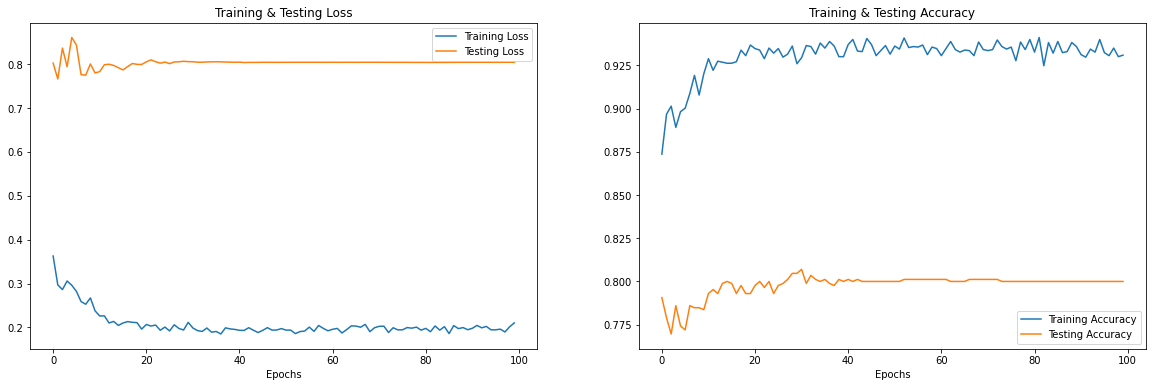

In [42]:
print("Accuracy of the fucking model on the fucking test data is : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [43]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [44]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0         surprise      surprise
1          disgust       disgust
2            angry         angry
3            angry         angry
4         surprise      surprise
5            happy         happy
6             fear          fear
7            happy         happy
8          neutral       neutral
9          disgust       disgust

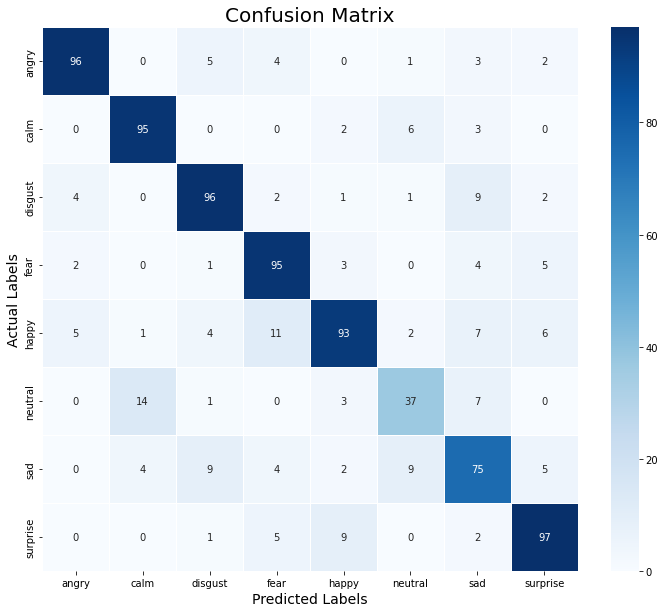

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.90      0.86      0.88       111
        calm       0.83      0.90      0.86       106
     disgust       0.82      0.83      0.83       115
        fear       0.79      0.86      0.82       110
       happy       0.82      0.72      0.77       129
     neutral       0.66      0.60      0.63        62
         sad       0.68      0.69      0.69       108
    surprise       0.83      0.85      0.84       114

    accuracy                           0.80       855
   macro avg       0.79      0.79      0.79       855
weighted avg       0.80      0.80      0.80       855

